In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

ot.RandomGenerator.SetSeed(42)

# KDE sur données spatiales

### Estimateur à noyau dans cadre spatial 

SOit un ensemble de données spatiales $(\mathbf{X}_1, \dots, \mathbf{X}_n)$ réparties aléatoirement dans un carré unitaire $[0,1]^2$, supposées provenant d’une variable aléatoire bidimensionnelle $X$ de densité de probabilité $p$. Le KDE permet d’estimer la densité $p$ à partir de l’échantillon, avec une approximation $\widehat{p}(\mathbf{x})$ de $p(\mathbf{x})$ pour tout point $\mathbf{x} \in [0,1]^2$.

En dimension $d = 2$, on utilise un noyau produit de deux noyaux unidimensionnels :
$$
K_2(\mathbf{x}) = K(x_1) \cdot K(x_2), \quad \text{où } \mathbf{x} = (x_1, x_2) \in [0,1]^2
$$


L'estimateur s’écrit :
$$
\widehat{p}(\mathbf{x}) = \frac{1}{n h_1 h_2} \sum_{i=1}^{n} K\left( \frac{x_1 - X_{i1}}{h_1} \right) \cdot K\left( \frac{x_2 - X_{i2}}{h_2} \right)
$$

où :

- $\mathbf{X}_i = (X_{i1}, X_{i2})$ est la $i$-ème observation spatiale
- $h_1$ et $h_2$ sont les fenêtres
- $K$ est le noyau gaussien



In [2]:
n_gaussians = 5
dimension = 2
n_samples = 10000

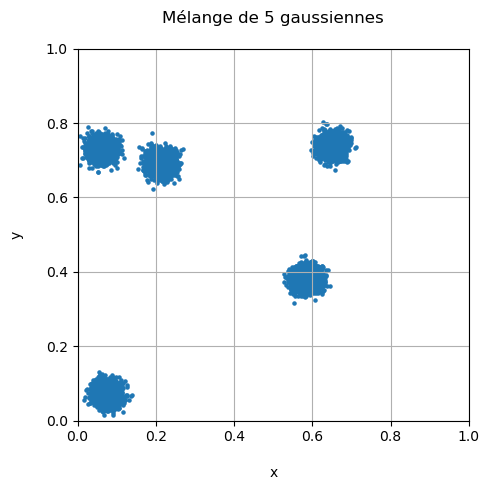

In [3]:
components = []
weights = []

for _ in range(n_gaussians):
    mu = [ot.RandomGenerator.Generate() for _ in range(dimension)]
    Sigma = ot.CovarianceMatrix(dimension)
    for i in range(dimension):
        Sigma[i, i] = 0.0003                 # variance faible pour visibilité
    
    gaussian = ot.Normal(mu, Sigma)
    components.append(gaussian)
    weights.append(1.0 / n_gaussians)        # poids uniforme pour chaque gaussienne 

mixture = ot.Mixture(components, weights)
sample = mixture.getSample(n_samples)
points = np.array(sample)


plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], s=5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Mélange de 5 gaussiennes\n")
plt.xlabel("\nx")
plt.ylabel("y\n")
plt.grid(True)
plt.tight_layout()
plt.show()

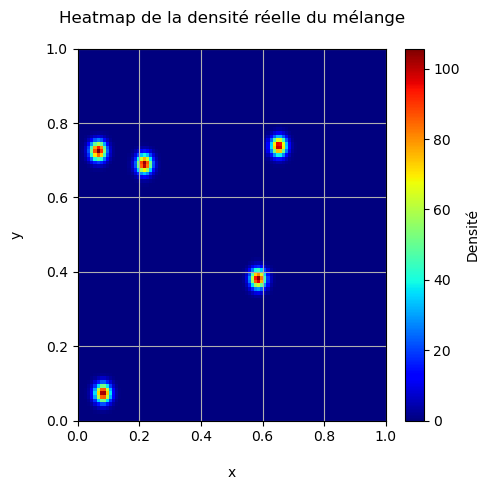

In [4]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

Z = np.array([mixture.computePDF(pt) for pt in grid_points])
true_density = Z.reshape(X.shape)

# --- Affichage ---
plt.figure(figsize=(5, 5))
plt.imshow(true_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Heatmap de la densité réelle du mélange\n")
plt.xlabel("\nx")
plt.ylabel("y\n")
plt.grid(True)
plt.colorbar(label="Densité")
plt.tight_layout()
plt.show()


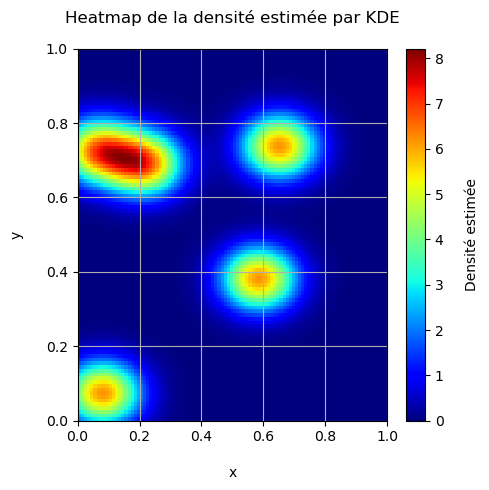

In [5]:
ks = ot.KernelSmoothing()
distribution = ks.build(sample)
Z = np.array([distribution.computePDF([x_, y_]) for x_, y_ in grid_points])
kde_density = Z.reshape(X.shape)

# Affichage Heatmap
plt.figure(figsize=(5, 5))
plt.imshow(kde_density, extent=[0, 1, 0, 1], origin="lower", cmap='jet', aspect='auto')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Heatmap de la densité estimée par KDE\n")
plt.xlabel("\nx")
plt.ylabel("y\n")
plt.grid(True)
plt.colorbar(label="\nDensité estimée")
plt.tight_layout()
plt.show()

In [6]:
ks.getBandwidth(), ks.computeSilvermanBandwidth(sample)

(class=Point name=Unnamed dimension=2 values=[0.0832178,0.0573741],
 class=Point name=Unnamed dimension=2 values=[0.0832178,0.0573741])

In [35]:
# Cross validation pour trouver une meilleure fenêtre h (isotrope)
def cv_bandwidth(data, bandwidths=np.logspace(-2, 0, 50)):
    grid = GridSearchCV(
        KernelDensity(kernel='gaussian'),
        {'bandwidth': bandwidths},
        cv=5
    )
    grid.fit(data)
    return grid.best_params_['bandwidth']

# Cross validation pour trouver de meilleures fenêtres h_1 et h_2(anisotrope)
def cv_bandwidth_anisotrope(data, bandwidths=np.logspace(-3, -1, 20)):
    best_bandwidths = []
    for dim in range(data.shape[1]):
        grid = GridSearchCV(
            KernelDensity(kernel='gaussian'),
            {'bandwidth': bandwidths},
            cv=5
        )
        grid.fit(data[:, dim][:, None]) 
        best_bandwidths.append(grid.best_params_['bandwidth'])
    return ot.Point(best_bandwidths)

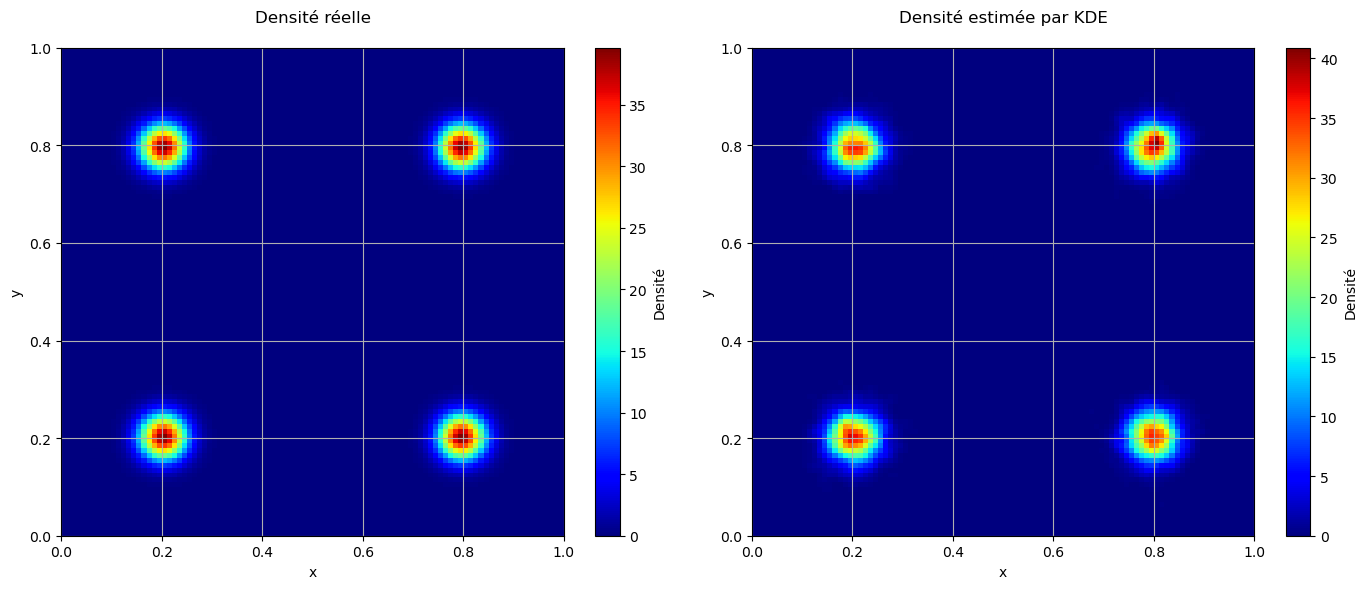

In [48]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

# Calcule de la vraie densité
Z_true = np.array([mixture.computePDF(ot.Point(pt)) for pt in grid_points])
true_density = Z_true.reshape(X.shape)

# Calcul de la densité du KDE, avec recherche d'une bonne bandwidth par CV
#best_bw = cv_bandwidth_anisotrope(points)
#bw_vector = ot.Point([best_bw] * dimension)
bw_vector = [ks.computeMixedBandwidth(sample[:,0])[0], ks.computeMixedBandwidth(sample[:,1])[0]]
#bw_vector = cv_bandwidth_anisotrope(points)
ks = ot.KernelSmoothing()
kde_dist = ks.build(sample, bw_vector)
Z_kde = np.array([kde_dist.computePDF(ot.Point([x_, y_])) for x_, y_ in grid_points])
kde_density = Z_kde.reshape(X.shape)


# Affichage
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im1 = axs[0].imshow(true_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[0].set_title("Densité réelle\n")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
fig.colorbar(im1, ax=axs[0], label="Densité")

im2 = axs[1].imshow(kde_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[1].set_title("Densité estimée par KDE\n")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
fig.colorbar(im2, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()


In [37]:
print(bw_vector)

[0.00695193,0.00695193]


In [34]:
np.logspace(-3, -1, 20)

array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])

In [43]:
ks.computeMixedBandwidth(sample[:,0]), ks.computePluginBandwidth(sample[:,0]), ks.computeSilvermanBandwidth(sample[:,0]) 

(class=Point name=Unnamed dimension=1 values=[0.00861242],
 class=Point name=Unnamed dimension=1 values=[0.0067172],
 class=Point name=Unnamed dimension=1 values=[0.0705639])

In [46]:
ks.computeMixedBandwidth(sample[:,0]), ks.computeMixedBandwidth(sample[:,1])

(class=Point name=Unnamed dimension=1 values=[0.00861242],
 class=Point name=Unnamed dimension=1 values=[0.00847737])

##### Cas avec les gaussiennes aux 4 coins

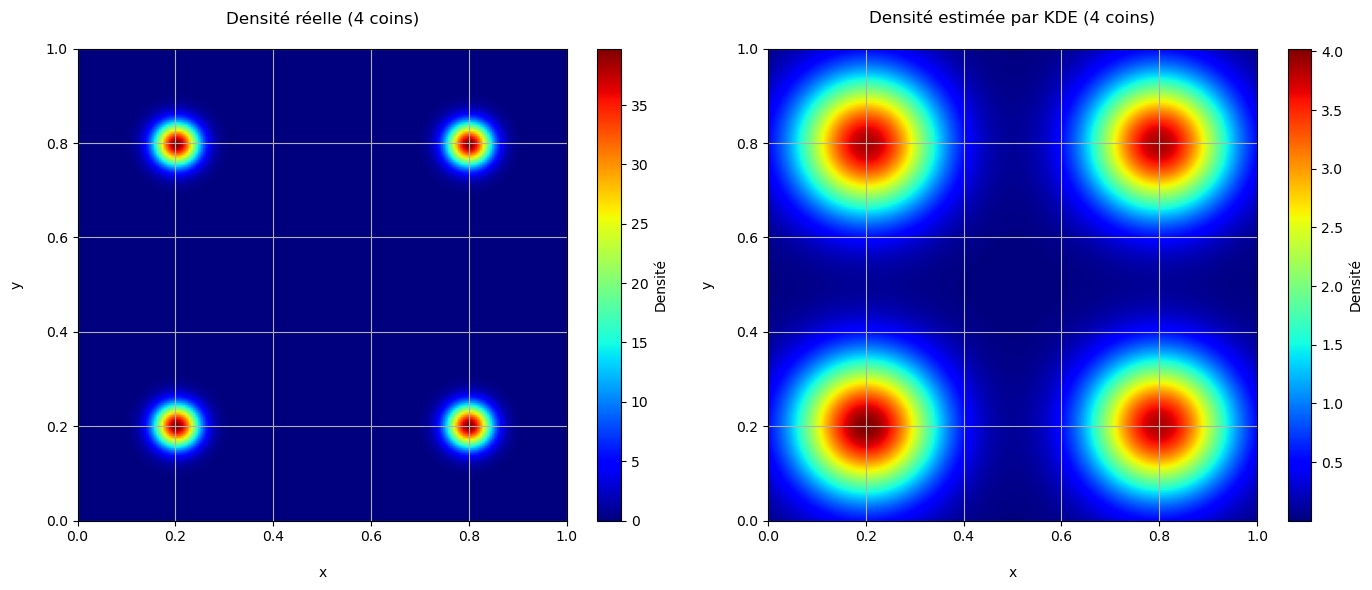

In [18]:
n_gaussians = 4
dimension = 2
n_samples = 10000
localisation_means = [[0.2, 0.2], [0.2, 0.8], [0.8, 0.2], [0.8, 0.8]]

components = []
weights = []

for mu in localisation_means:
    Sigma = ot.CovarianceMatrix(dimension)
    for i in range(dimension):
        Sigma[i, i] = 0.001 
    
    gaussian = ot.Normal(mu, Sigma)
    components.append(gaussian)
    weights.append(1.0 / n_gaussians)

mixture = ot.Mixture(components, weights)
sample = mixture.getSample(n_samples)
points = np.array(sample)

x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

# Calcule de la vraie densité
Z_true = np.array([mixture.computePDF(pt) for pt in grid_points])
true_density = Z_true.reshape(X.shape)

# Calcul de la densité du KDE
ks = ot.KernelSmoothing()
kde_dist = ks.build(sample)
Z_kde = np.array([kde_dist.computePDF([x_, y_]) for x_, y_ in grid_points])
kde_density = Z_kde.reshape(X.shape)


# Affichage
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im1 = axs[0].imshow(true_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[0].set_title("Densité réelle (4 coins)\n")
axs[0].set_xlabel("\nx")
axs[0].set_ylabel("y\n")
axs[0].grid(True)
fig.colorbar(im1, ax=axs[0], label="Densité")

im2 = axs[1].imshow(kde_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[1].set_title("Densité estimée par KDE (4 coins)\n")
axs[1].set_xlabel("\nx")
axs[1].set_ylabel("y\n")
axs[1].grid(True)
fig.colorbar(im2, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()

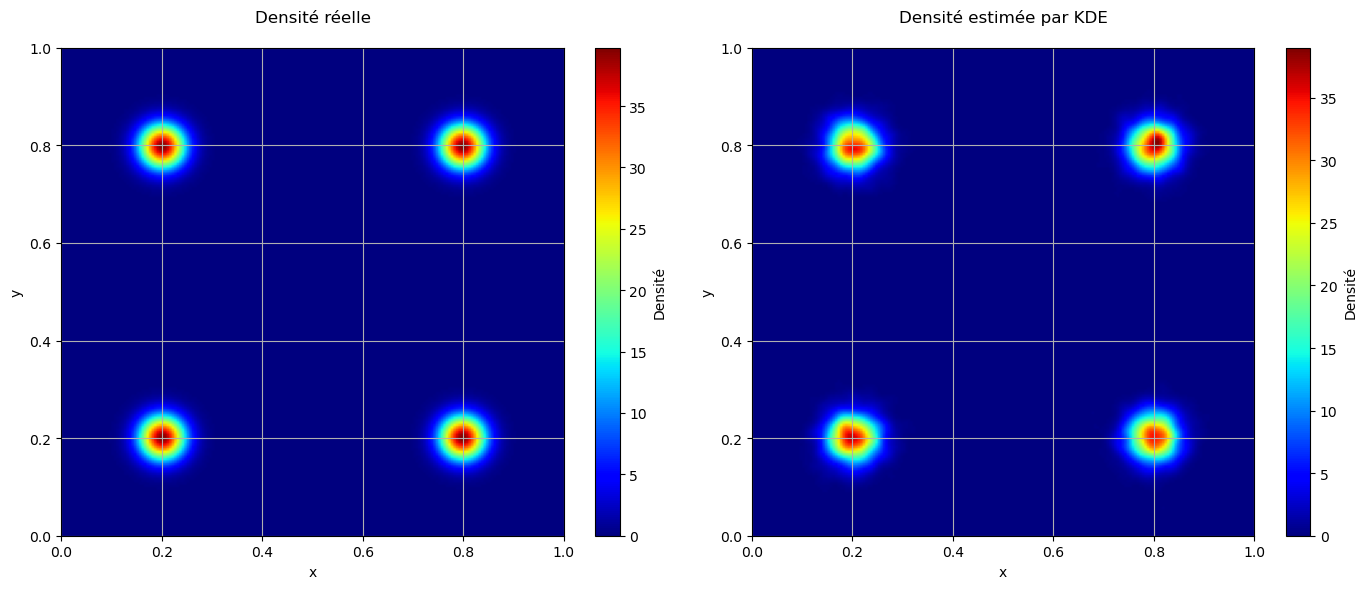

In [19]:
# Calcul de la densité du KDE, avec recherche d'une bonne bandwidth par CV
best_bw = cv_bandwidth(points)
bw_vector = ot.Point([best_bw] * dimension)
ks = ot.KernelSmoothing()
kde_dist = ks.build(sample, bw_vector)
Z_kde = np.array([kde_dist.computePDF(ot.Point([x_, y_])) for x_, y_ in grid_points])
kde_density = Z_kde.reshape(X.shape)


# Affichage
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im1 = axs[0].imshow(true_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[0].set_title("Densité réelle\n")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
fig.colorbar(im1, ax=axs[0], label="Densité")

im2 = axs[1].imshow(kde_density, extent=[0, 1, 0, 1], origin='lower', cmap='jet', aspect='auto')
axs[1].set_title("Densité estimée par KDE\n")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
fig.colorbar(im2, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()

### Améliorations éventuelles : https://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_model_singular_multivariate_distribution.html?highlight=empiricalbernstein